# Pipeline

## Imports

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import optuna

## Dataset

In [100]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


## PreProcess Pipeline

We discussed various problematics in the EDA notebook. To address the problems of our dataset we are going to build a Pipeline which will give a suitable dataset. Indeed, we are going to firstly remove all the meaningless data, including misinformation and least and too correlated with our target variable. Then we are going to encode the categorical variables and to solve the problem of the different scale and the skewness we are going to log transform price and stabdardize between [-1,1] all data points. Lastly, as an optional we are going to treat the dataset with either Isoaltion Forest, an algorithm to remove outliers, and or PCA, dimensionality reduction technique. Given the dimensionality of the dataset we do not expect the latter techniques to work better, but for the sake of completness we will try every combination. 

### Utils

In [101]:
# Given a dataset, let us distinguish numerical and categorical variables
def feature_type(data):
    categorical = data.select_dtypes(include=['object']).columns.tolist()
    numerical = data.select_dtypes(include=['number']).columns.tolist()
    return categorical,numerical

# Let us understand which variables to remove based on correlation
def correlated_features(data):
    # We will see the linear correlation with the target variable price
    corr_dict = dict(np.abs(data.corr()['price']))
    # Let us remove price
    del corr_dict['price']
    # Now let us keep track of the features to remove starting with the least correlated ones
    # without loss of generality we will remove all variables with correlation below 0.05 
    delete_col = [k for k, v in corr_dict.items() if v < 0.05]
    # Now let us remove variables with analogus values so similar correlation
    for ix, keys in enumerate(list(corr_dict.keys()),1):
        if keys in delete_col:
            continue
        else:
            for keys2 in list(corr_dict.keys())[ix:]:
                # if variables are very correlated between them selves I remove one of them
                if np.abs(corr_dict[keys] - corr_dict[keys2]) < 0.01 :
                    delete_col.append(keys)
                    break
    return delete_col
# Let us save the variable which remain after the elimination
def remaining_var(data):
    delete = correlated_features(data)
    cat,num = feature_type(data)
    rem_num = [feature for feature in num if feature not in delete]
    rem_cat = [feature for feature in cat if feature not in delete]
    return rem_cat,rem_num

Here I am re-defining all the process we will need for our pipeline since I would like to process both features and labels in the same pipeline and It is desirable to keep pandas format.

In [102]:
# Class to drop columns in the dataset
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        # assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        # Drop columns
        return X.drop(columns = self.columns)
# Class to remove rows originated by errors in the dataset   
class RemoveErrorsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        # assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            # All the variables should be positive given their meaning
            X = X[X[col]>0]
        return X      

# you can log transform chosen columns (in our case it will be price, the label)
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        # assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # log transforming of a column
            X[col] = np.log1p(X[col])
        return X

# One hot encode categorical variables  
class ModifiedOnehotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        # assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        # use get_dummies function to create dummy variables for each value
        #  for every categorical value
        X_encod = pd.get_dummies(X, columns= self.columns, drop_first=True)
        return X_encod

# Scale numerical columns based on mean and standard deviation   
class ModifiedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        # assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            # Standardize with mean and standard deviation in the column
            X[col] = (X[col] - X[col].mean()) / X[col].std()
        return X

# Remove outliers
class IsolationForestTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.model = IsolationForest()  
    def fit(self,X,y=None):
        self.model.fit(X)
        return self
    def transform(self,X):
        X = X.copy()
        pred = self.model.predict(X)
        # Take only the one which were classified as not outliers
        X = X[pred == 1]  
        return X
class PCATransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        # without loss of generality keep 95% of varinace
        self.model = PCA(n_components=0.95)
        self.index = None
    def fit(self,X,y = None):
        # I have to transpose since PCA works on the dimensionality reduction of columns
        self.model.fit(X.T)
        return self
    def transform(self,X):
        X_tr = X.T
        reduced_df = self.model.transform(X_tr)
        index = [f'PC{i+1}' for i in range(reduced_df.shape[1])]
        self.index = index
        # Return a dataset with modified rows
        reduced_df = pd.DataFrame(reduced_df.T, columns= X.columns ,index= self.index)
        return reduced_df

### Preprocess Pipeline 

In [103]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer)])


C:\Users\len\AppData\Local\Temp\ipykernel_7388\3703874678.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### PreProcess Pipeline with Isolation Forest

In [104]:
numeric_transformer1 = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds)))])
numeric_transformer2 = Pipeline(steps = [('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso = Pipeline(steps=[('preprocess_num1',numeric_transformer1),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer()),
                               ('preprocess_num2',numeric_transformer2)])

C:\Users\len\AppData\Local\Temp\ipykernel_7388\3703874678.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Preprocess pipeline with PCA

In [105]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_pca = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer),
                               ('dimensionality_reduction',PCATransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_7388\3703874678.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Preprocess pipeline with PCA and Isolation Forest

In [106]:
numeric_transformer1 = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds)))])
numeric_transformer2 = Pipeline(steps = [('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso_pca = Pipeline(steps=[('preprocess_num1',numeric_transformer1),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer()),
                               ('preprocess_num2',numeric_transformer2),
                               ('dimensionality_reduction',PCATransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_7388\3703874678.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Final General Pipeline

In [107]:
class ModelOptimizer:
    def __init__(self):
        self.models = ['LinearRegression', 'XGBRegressor', 'Ridge']
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.pred = None
        self.model_name = None
    
    def plot_gof(self, y_true: pd.Series, y_pred: pd.Series, model_name):
        plt.plot(y_true, y_pred, '.')
        plt.plot(y_true, y_true, linewidth=3, c='black')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(model_name + ' performances')
        plt.show()
    
    def objective(self, trial: optuna.trial.Trial, X_train, X_test, y_train, y_test, model_available) -> float:
        
        if model_available == 'LinearRegression':
            param = {
                'copy_X': True,
                'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
                'n_jobs': None,
                'positive': False
            }
            model = LinearRegression(**param)
        
        elif model_available == 'XGBRegressor':
            param = {
                'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
                'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.7]),
                'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 9),
                'random_state': 42,
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'enable_categorical': True
            }
            model = XGBRegressor(**param)
        
        elif model_available == 'Ridge':
            param = {
                'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
                'copy_X': True,
                'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
                'max_iter': None,
                'positive': False,
                'random_state': 123,
                'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
                'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
            }
            model = Ridge(**param)
        
        else:
            print(f"The only models in this server are {self.models}, use one of these or contact the creator")
            return None
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        return mae

    def full_pipeline(self, preprocess, data, model_available, model_name):
        assert isinstance(model_name, str)
        self.model_name = model_name
        if model_available not in self.models:
            print(f"The only models in this server are {self.models}, use one of these or contact the creator")
            return None
        
        y = data['price']
        X = data.drop(columns=['price'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        data_train = self.X_train.assign(price=self.y_train)
        data_test = self.X_test.assign(price=y_test)
        
        preprocess.fit(data_train)
        data_processed_train = preprocess.transform(data_train)
        preprocess.fit(data_test)
        data_processed_test = preprocess.transform(data_test)
        
        self.X_train,self.y_train = data_processed_train.drop(columns=['price']), data_processed_train['price']
        self.X_test, self.y_test = data_processed_test.drop(columns=['price']), data_processed_test['price']
        
        study = optuna.create_study(direction='minimize', study_name=f'Diamonds {model_available}')
        study.optimize(lambda trial: self.objective(trial, self.X_train, self.X_test, self.y_train, self.y_test, model_available), n_trials=100)
        
        if model_available == 'LinearRegression':
            model = LinearRegression(**study.best_params)
        elif model_available == 'XGBRegressor':
            model = XGBRegressor(**study.best_params)
        elif model_available == 'Ridge':
            model = Ridge(**study.best_params)
        
        model.fit(self.X_train, self.y_train)
        self.pred = model.predict(self.X_test)
        
        stats = pd.DataFrame(np.zeros((1, 2)), index=[model_name], columns=['MAE', 'R2'])
        stats['MAE'][model_name] = round(mean_absolute_error(self.y_test, self.pred), 4)
        stats['R2'][model_name] = round(r2_score(self.y_test, self.pred), 4)
        # Put it in transpose
        stats = stats.T
    
        return stats
    def plot(self):
        self.plot_gof(self.y_test, self.pred, self.model_name)



## Statistics recording

I will create a dataset to record all mean absolute errors and R2 score to keep the performances of all employed models

In [116]:
stats = pd.DataFrame(np.zeros((2,1)),columns=['col'],index = ['MAE','R2'])

## Linear Model Pipeline

### Only preprocessing

In [117]:
optim = ModelOptimizer()
model_name = 'Linear Regression'
linear_reg = optim.full_pipeline(preprocessor,diamonds,'LinearRegression',model_name)

[I 2024-07-02 00:39:58,371] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 00:39:58,378] Trial 0 finished with value: 0.14022568116673825 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.14022568116673825.
[I 2024-07-02 00:39:58,404] Trial 1 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 0.13046866762157458.
[I 2024-07-02 00:39:58,418] Trial 2 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 0.13046866762157458.
[I 2024-07-02 00:39:58,425] Trial 3 finished with value: 0.14022568116673825 and parameters: {'fit_intercept': False}. Best is trial 1 with value: 0.13046866762157458.
[I 2024-07-02 00:39:58,441] Trial 4 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 0.13046866762157458.
[I 2024-07-02 00:39:58,458] Trial 5 finished with value: 0.140225681

In [118]:
linear_reg

,Linear Regression
MAE,0.1305
R2,0.9681


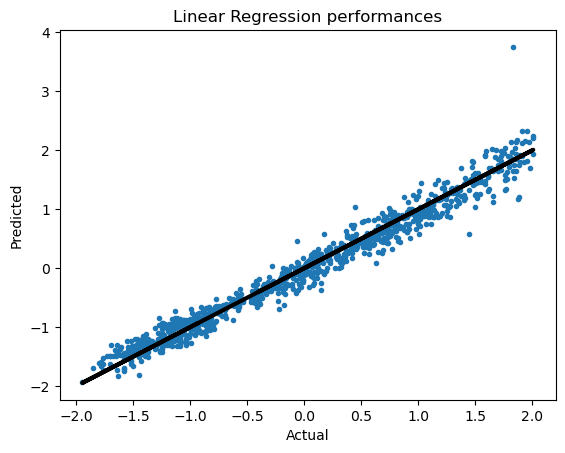

In [119]:
optim.plot()

In [120]:
# Add to dataset
stats[model_name] = linear_reg

###  Isolation Forest

In [121]:
optim = ModelOptimizer()
model_name = 'Linear Regression Isolation Forest'
linear_regr_iso = optim.full_pipeline(preprocessor_iso,diamonds,'LinearRegression',model_name)

[I 2024-07-02 00:40:08,121] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 00:40:08,150] Trial 0 finished with value: 0.13634544621269942 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13634544621269942.
[I 2024-07-02 00:40:08,167] Trial 1 finished with value: 0.1478208407134254 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.13634544621269942.
[I 2024-07-02 00:40:08,184] Trial 2 finished with value: 0.13634544621269942 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13634544621269942.
[I 2024-07-02 00:40:08,199] Trial 3 finished with value: 0.1478208407134254 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.13634544621269942.
[I 2024-07-02 00:40:08,213] Trial 4 finished with value: 0.1478208407134254 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.13634544621269942.
[I 2024-07-02 00:40:08,230] Trial 5 finished with value: 0.13634544621

In [122]:
linear_regr_iso

,Linear Regression Isolation Forest
MAE,0.1363
R2,0.9691


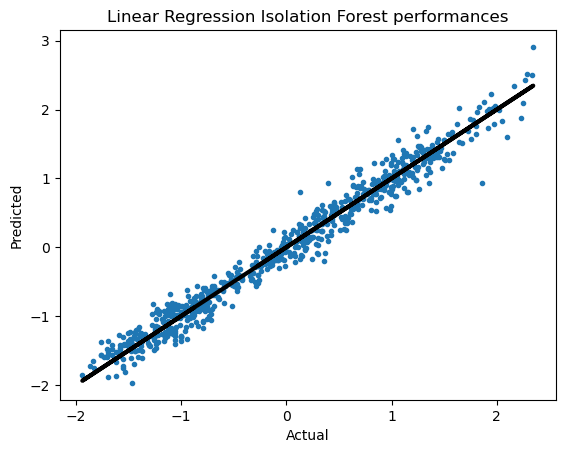

In [123]:
optim.plot()

In [124]:
# Add to dataset
stats[model_name] = linear_regr_iso

###  PCA

In [125]:
optim = ModelOptimizer()
model_name = 'Linear Regression PCA'
linear_regr_pca = optim.full_pipeline(preprocessor_pca,diamonds,'LinearRegression',model_name)

[I 2024-07-02 00:40:20,654] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 00:40:20,668] Trial 0 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 00:40:20,678] Trial 1 finished with value: 0.4155037210917021 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 00:40:20,687] Trial 2 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 00:40:20,696] Trial 3 finished with value: 0.4155037210917021 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 00:40:20,703] Trial 4 finished with value: 0.4155037210917021 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 00:40:20,715] Trial 5 finished with value: 0.3825267275928536 an

In [126]:
linear_regr_pca

,Linear Regression PCA
MAE,0.3825
R2,0.9950


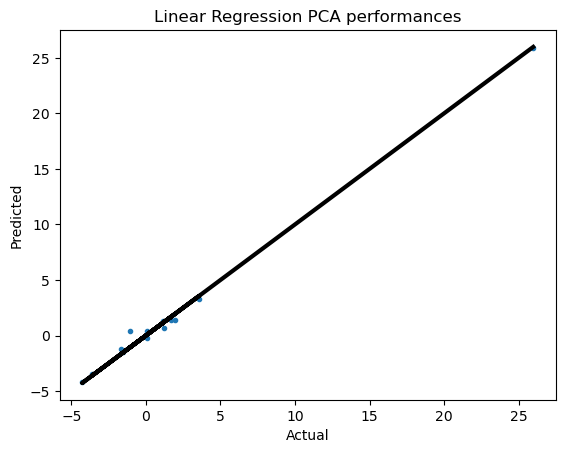

In [127]:
optim.plot()

In [128]:
# Add to dataset
stats[model_name] = linear_regr_pca

### Isolation Forest and PCA 

In [129]:
optim = ModelOptimizer()
model_name = 'Linear Regression Isolation Forest and PCA'
linear_regr_iso_pca = optim.full_pipeline(preprocessor_iso_pca,diamonds,'LinearRegression',model_name)

[I 2024-07-02 00:40:29,516] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 00:40:29,532] Trial 0 finished with value: 0.38194875167668885 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.38194875167668885.
[I 2024-07-02 00:40:29,551] Trial 1 finished with value: 1.3493281556516317 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.38194875167668885.
[I 2024-07-02 00:40:29,561] Trial 2 finished with value: 0.38194875167668885 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.38194875167668885.
[I 2024-07-02 00:40:29,570] Trial 3 finished with value: 0.38194875167668885 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.38194875167668885.
[I 2024-07-02 00:40:29,579] Trial 4 finished with value: 0.38194875167668885 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.38194875167668885.
[I 2024-07-02 00:40:29,590] Trial 5 finished with value: 1.34932815

In [130]:
linear_regr_iso_pca

,Linear Regression Isolation Forest and PCA
MAE,0.3819
R2,0.9925


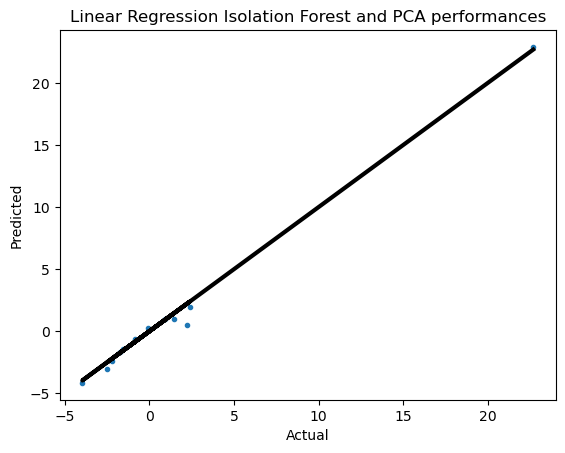

In [131]:
optim.plot()

In [132]:
# Add to dataset
stats[model_name] = linear_regr_iso_pca

## XGBoost Pipeline

### Preprocessing

In [133]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression'
xgb_regr = optim.full_pipeline(preprocessor,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 00:40:36,736] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 00:40:38,033] Trial 0 finished with value: 0.8573365623814186 and parameters: {'lambda': 0.0009645207867151764, 'alpha': 7.81881196322226e-06, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 4.033586688426632e-08, 'n_estimators': 412, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 0 with value: 0.8573365623814186.
[I 2024-07-02 00:40:38,696] Trial 1 finished with value: 0.8159592784642412 and parameters: {'lambda': 0.0003864811495068175, 'alpha': 0.571182949546086, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 9.440357280028344e-05, 'n_estimators': 736, 'max_depth': 3, 'min_child_weight': 8}. Best is trial 1 with value: 0.8159592784642412.
[I 2024-07-02 00:40:40,854] Trial 2 finished with value: 0.779030752747651 and parameters: {'lambda': 0.11864743142169558, 'alpha': 1.732790240820184e-07, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate':

In [134]:
xgb_regr

,XGBoost Regression
MAE,0.1079
R2,0.9791


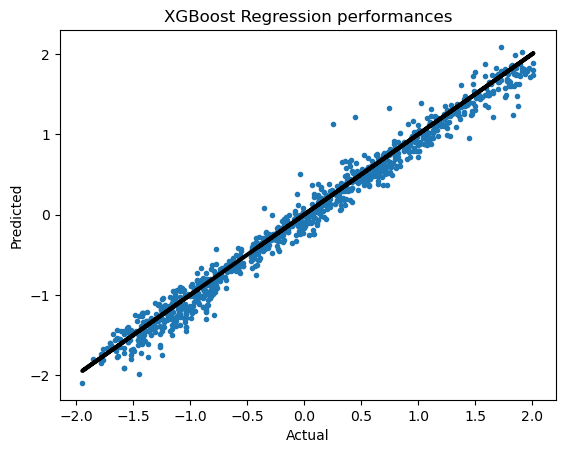

In [135]:
optim.plot()

In [136]:
# Add to dataset
stats[model_name] = xgb_regr

### Isolation Forest

In [137]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression Isolation Forest'
xgb_regr_iso = optim.full_pipeline(preprocessor_iso,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 00:42:14,000] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 00:42:14,930] Trial 0 finished with value: 0.8604676748866475 and parameters: {'lambda': 0.03620100756668633, 'alpha': 0.045039083203089074, 'colsample_bytree': 0.3, 'subsample': 0.9, 'learning_rate': 5.583687462875764e-07, 'n_estimators': 464, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 0 with value: 0.8604676748866475.
[I 2024-07-02 00:42:15,396] Trial 1 finished with value: 0.26321783435849366 and parameters: {'lambda': 1.881608452333925e-05, 'alpha': 0.5951825669542742, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.004588497026053004, 'n_estimators': 571, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 1 with value: 0.26321783435849366.
[I 2024-07-02 00:42:16,172] Trial 2 finished with value: 0.8602027304648534 and parameters: {'lambda': 7.918995855153938e-07, 'alpha': 2.354867421782009e-08, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rat

In [138]:
xgb_regr_iso

,XGBoost Regression Isolation Forest
MAE,0.1266
R2,0.9678


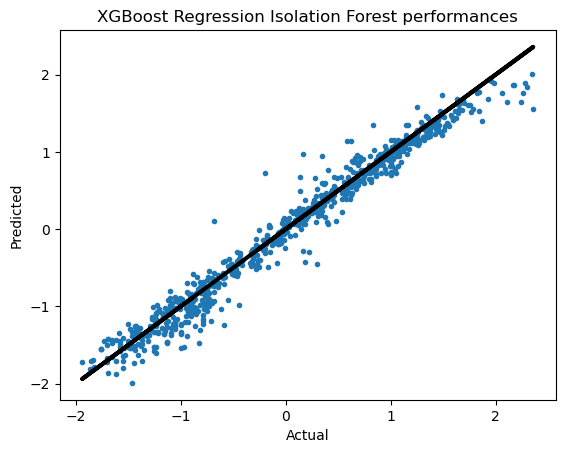

In [139]:
optim.plot()

In [140]:
# Add to dataset
stats[model_name] = xgb_regr_iso

###  PCA

In [141]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression PCA'
xgb_regr_pca = optim.full_pipeline(preprocessor_pca,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 00:43:34,153] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 00:43:34,667] Trial 0 finished with value: 4.204262703165066 and parameters: {'lambda': 1.7806152308044803e-06, 'alpha': 2.214279263878691e-08, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.0002063284142726345, 'n_estimators': 898, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 0 with value: 4.204262703165066.
[I 2024-07-02 00:43:34,917] Trial 1 finished with value: 4.812685679438823 and parameters: {'lambda': 3.376325485793799e-05, 'alpha': 3.5799056507134657e-07, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 8.743047483085542e-08, 'n_estimators': 465, 'max_depth': 3, 'min_child_weight': 4}. Best is trial 0 with value: 4.204262703165066.
[I 2024-07-02 00:43:35,170] Trial 2 finished with value: 4.8114094064450015 and parameters: {'lambda': 8.017011686088187e-05, 'alpha': 5.0260517855785905e-08, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning

In [142]:
xgb_regr_pca

,XGBoost Regression PCA
MAE,2.4383
R2,0.7640


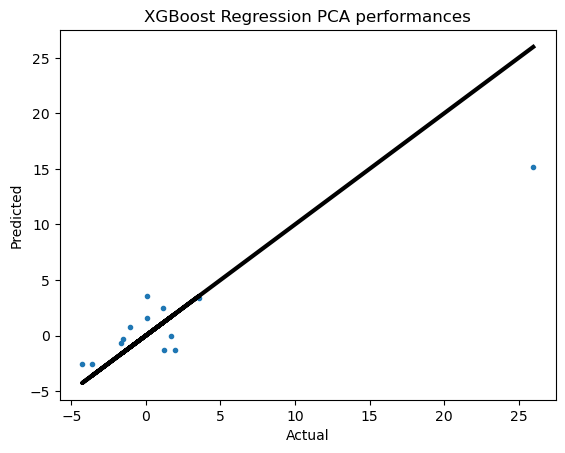

In [143]:
optim.plot()

In [144]:
# Add to dataset
stats[model_name] = xgb_regr_pca

### Isolation Forest and PCA

In [145]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression Isolation Forest PCA'
xgb_regr_iso_pca = optim.full_pipeline(preprocessor_iso_pca,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 00:44:23,730] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 00:44:23,961] Trial 0 finished with value: 5.059088052187945 and parameters: {'lambda': 2.44050797146824e-08, 'alpha': 0.015870461796825983, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 2.9055057367701995e-06, 'n_estimators': 338, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 0 with value: 5.059088052187945.
[I 2024-07-02 00:44:24,360] Trial 1 finished with value: 5.273566207165107 and parameters: {'lambda': 4.561408028984427e-06, 'alpha': 0.23546859672994197, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.000291090171963692, 'n_estimators': 916, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 0 with value: 5.059088052187945.
[I 2024-07-02 00:44:24,704] Trial 2 finished with value: 5.058527371162757 and parameters: {'lambda': 7.39147134209391e-08, 'alpha': 3.717983726256292e-05, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 3

In [146]:
xgb_regr_iso_pca

,XGBoost Regression Isolation Forest PCA
MAE,1.9175
R2,0.7001


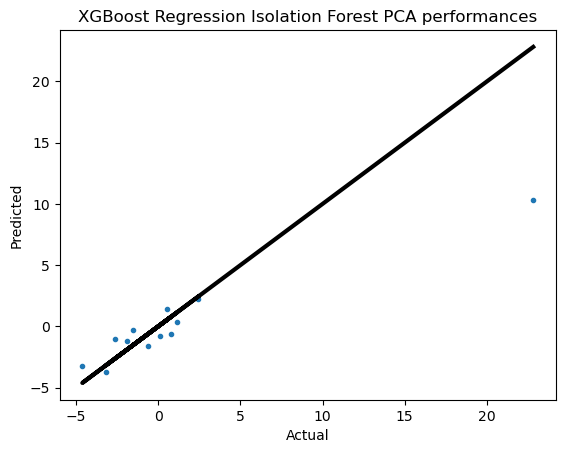

In [147]:
optim.plot()

In [148]:
# Add to dataset
stats[model_name] = xgb_regr_iso_pca

## Ridge Regression Pipeline

### Only preprocessing

In [149]:
optim = ModelOptimizer()
model_name = 'Ridge Regression'
ridge_regr = optim.full_pipeline(preprocessor,diamonds,'Ridge',model_name)

[I 2024-07-02 00:45:12,522] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 00:45:12,544] Trial 0 finished with value: 0.1488165300068753 and parameters: {'alpha': 8.026238060749737, 'fit_intercept': False, 'solver': 'sag', 'tol': 0.0439198017420803}. Best is trial 0 with value: 0.1488165300068753.
C:\Users\len\AppData\Local\Tem

In [150]:
ridge_regr

,Ridge Regression
MAE,0.1305
R2,0.9681


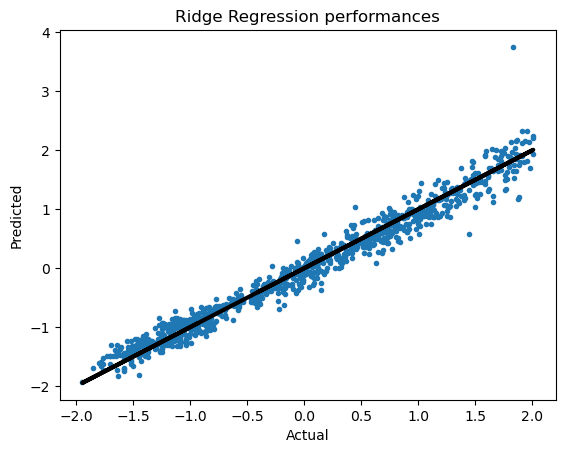

In [151]:
optim.plot()

In [152]:
# Add to dataset
stats[model_name] = ridge_regr

### Isolation Forest

In [153]:
optim = ModelOptimizer()
model_name = 'Ridge Regression Isolation Forest'
ridge_regr_iso = optim.full_pipeline(preprocessor_iso,diamonds,'Ridge',model_name)

[I 2024-07-02 00:45:22,781] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 00:45:22,792] Trial 0 finished with value: 0.1508266091891705 and parameters: {'alpha': 0.0005274559301748511, 'fit_intercept': False, 'solver': 'sparse_cg', 'tol': 0.00032265858998685736}. Best is trial 0 with value: 0.1508266091891705.
C:\Users\len\App

In [154]:
ridge_regr_iso

,Ridge Regression Isolation Forest
MAE,0.1388
R2,0.9679


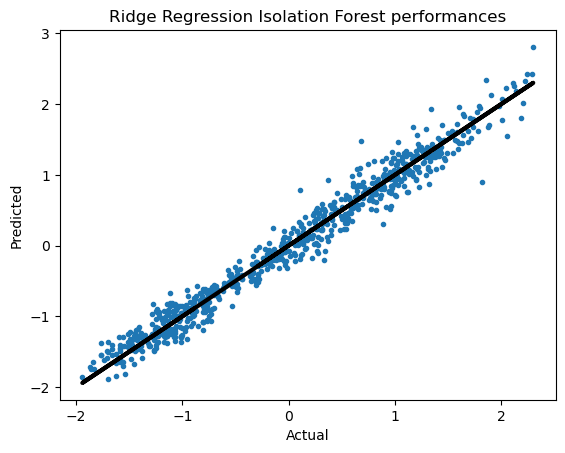

In [155]:
optim.plot()

In [156]:
# Add to dataset
stats[model_name] = ridge_regr_iso

### PCA

In [157]:
optim = ModelOptimizer()
model_name = 'Ridge Regression PCA'
ridge_regr_pca = optim.full_pipeline(preprocessor_pca,diamonds,'Ridge',model_name)

[I 2024-07-02 00:45:27,729] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 00:45:27,744] Trial 0 finished with value: 0.4154630541817401 and parameters: {'alpha': 0.00016903879148033282, 'fit_intercept': True, 'solver': 'sparse_cg', 'tol': 9.19979677233876e-05}. Best is trial 0 with value: 0.4154630541817401.
C:\Users\len\AppDa

In [158]:
ridge_regr_pca

,Ridge Regression PCA
MAE,0.3733
R2,0.9951


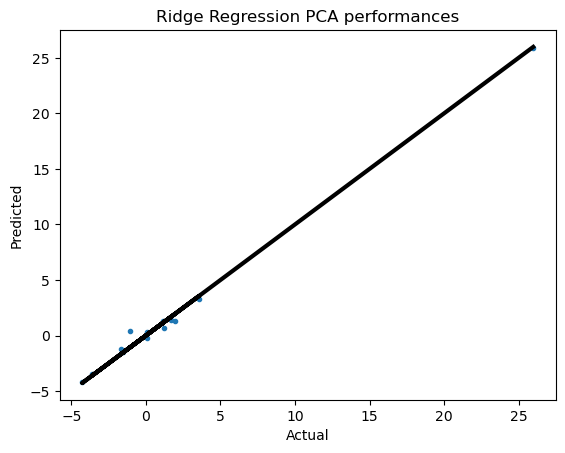

In [159]:
optim.plot()

In [160]:
# Add to dataset
stats[model_name] = ridge_regr_pca

### Isolation Forest and PCA

In [161]:
optim = ModelOptimizer()
model_name = 'Ridge Regression Isolation Forest PCA'
ridge_regr_iso_pca = optim.full_pipeline(preprocessor_iso_pca,diamonds,'Ridge',model_name)

[I 2024-07-02 00:45:32,861] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_7388\693308192.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 00:45:32,873] Trial 0 finished with value: 0.44319760571413386 and parameters: {'alpha': 0.0021703571288489423, 'fit_intercept': True, 'solver': 'auto', 'tol': 2.2102113263227304e-06}. Best is trial 0 with value: 0.44319760571413386.
C:\Users\len\AppData

In [162]:
ridge_regr_iso_pca

,Ridge Regression Isolation Forest PCA
MAE,0.4284
R2,0.9927


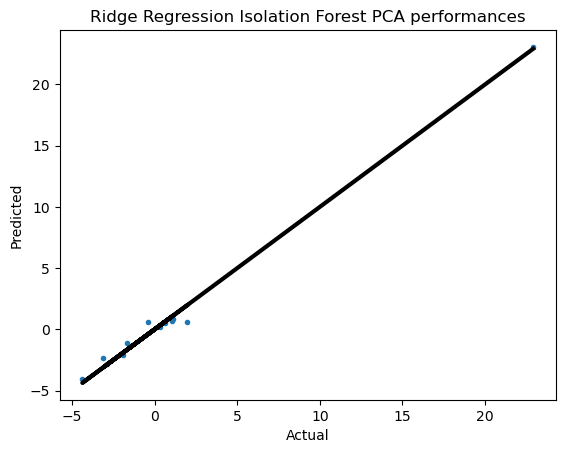

In [163]:
optim.plot()

In [164]:
# Add to dataset
stats[model_name] = ridge_regr_iso_pca

### Final Statistics

In [165]:
stats_final = stats.copy()
del stats_final['col']
stats_final = stats_final.T
stats_final

,MAE,R2
Linear Regression,0.1305,0.9681
Linear Regression Isolation Forest,0.1363,0.9691
Linear Regression PCA,0.3825,0.9950
Linear Regression Isolation Forest and PCA,0.3819,0.9925
XGBoost Regression,0.1079,0.9791
XGBoost Regression Isolation Forest,0.1266,0.9678
XGBoost Regression PCA,2.4383,0.7640
XGBoost Regression Isolation Forest PCA,1.9175,0.7001
Ridge Regression,0.1305,0.9681
Ridge Regression Isolation Forest,0.1388,0.9679
